/home/weeb/.conda/envs/igwn-py310/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Starting data analysis and table generation...
Successfully saved data tables to './tables' directory.


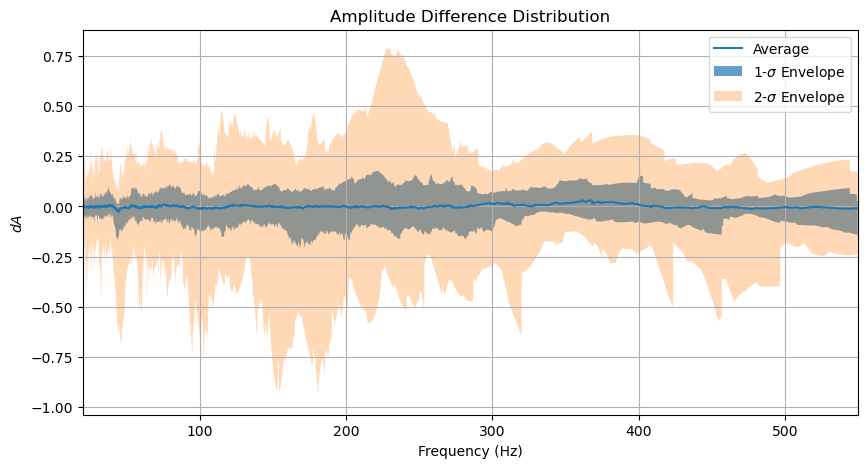

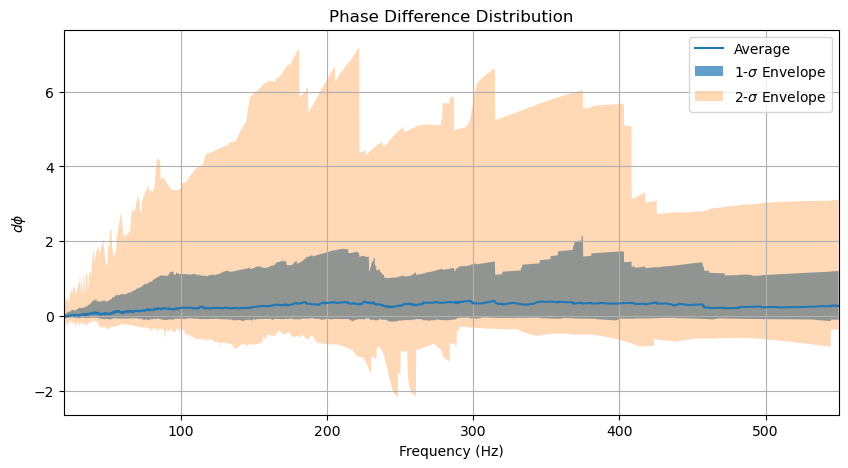

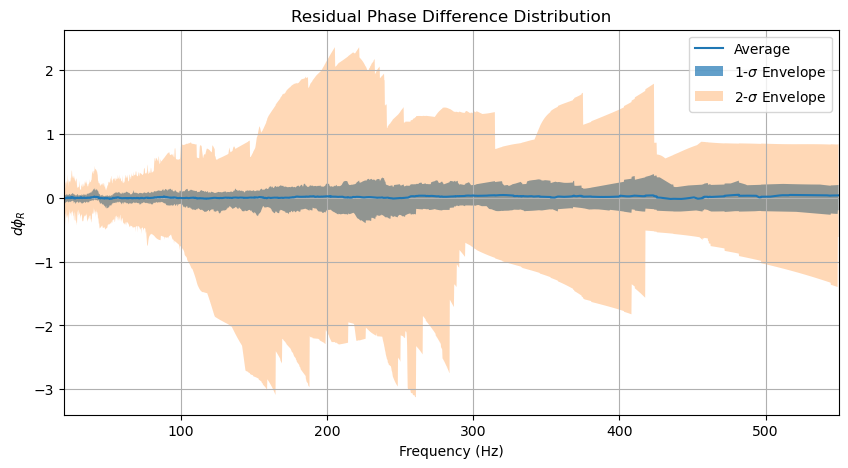

Generating envelope plots for dimensionless frequency...


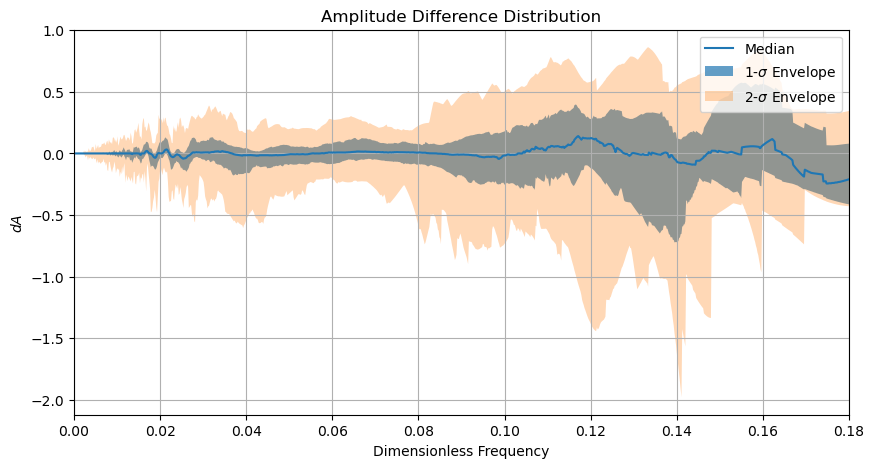

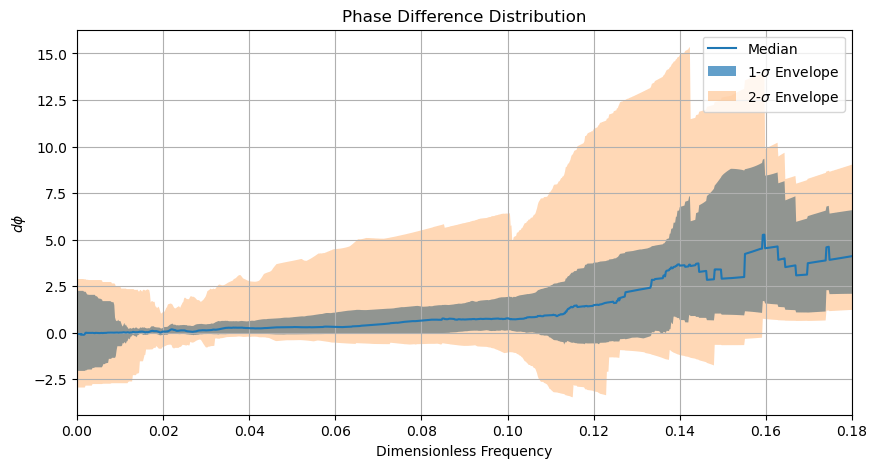

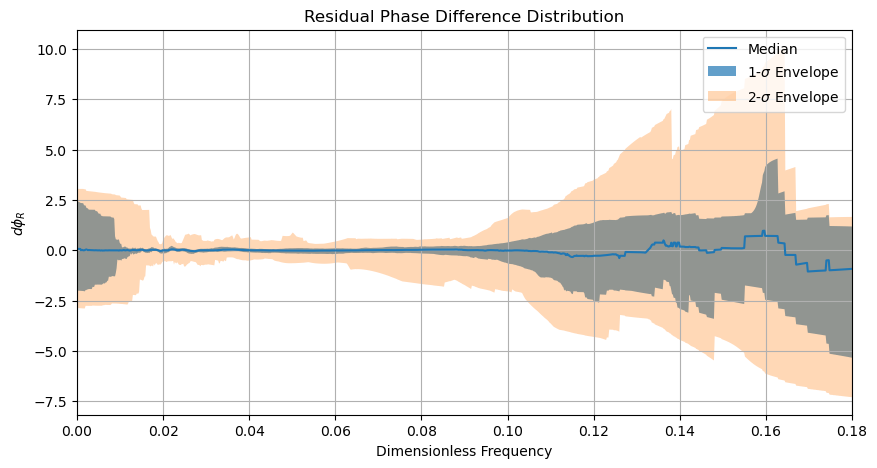

In [ ]:
# Get rid of warnings
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "src")))

# Set up proper LAL Data Path (Needed for accessing SEOBNR files)
os.environ['LAL_DATA_PATH'] = os.path.expanduser(
    "~/gw-analysis/data/lalsuite-extra/data/lalsimulation")

import lal
import pycbc
from pycbc.waveform import get_fd_waveform
import numpy as np

import constants
import gwtc
import utils

def generate_waveform(parameter, wfm_a, wfm_b):
    mass1 = parameter['mass_1']
    mass2 = parameter['mass_2']
    distance = parameter['luminosity_distance']
    inclination = parameter['iota']

    spin1x = parameter['spin_1x']
    spin1y = parameter['spin_1y']
    spin1z = parameter['spin_1z']
    spin2x = parameter['spin_2x']
    spin2y = parameter['spin_2y']
    spin2z = parameter['spin_2z']

    if mass1 < mass2:
        mass1, mass2 = mass2, mass1
        spin1x, spin2x = spin2x, spin1x
        spin1y, spin2y = spin2y, spin1y
        spin1z, spin2z = spin2z, spin1z
    
    mass_ratio = mass2 / mass1
    total_mass = mass1 + mass2
    chi_eff = (mass1*spin1z + mass2*spin2z) / total_mass

    waveforms = {}
    for model in [wfm_a, wfm_b]:
        params = {
            'mass1': mass1,
            'mass2': mass2,
            'spin1z': spin1z,
            'spin2z': spin2z,
            'distance': distance,
            'inclination': inclination,
            'delta_f': constants.DELTA_F,
            'f_lower': constants.F_LOWER,
            'f_ref': constants.F_REF
        }
        
        if constants.USE_PRECESSING and model in constants.PRECESSING_MODELS:
            params['spin1x'] = spin1x
            params['spin1y'] = spin1y
            params['spin2x'] = spin2x
            params['spin2y'] = spin2y

        hp, hc = get_fd_waveform(approximant=model, **params)
        waveforms[model] = hp

    waveforms, h1, h2 = utils.truncate_waveform(waveforms, wfm_a, wfm_b)

    return (waveforms, h1, h2, 
            mass_ratio, total_mass, 
            chi_eff)

# Main Stuff
waveform_data = {}

for event in gwtc.ALL_EVENTS:
    samples = utils.get_parameters(event)

    for wfm_a, wfm_b in constants.MODEL_PAIRS:
        label = f"{event} {wfm_a} vs {wfm_b}"
        waveform_data[label] = []

        for parameter in samples:
            (waveforms, h1, h2, 
             mass_ratio, total_mass, 
             chi_eff) = generate_waveform(parameter, wfm_a, wfm_b)
            
            freqs = h1.sample_frequencies
            ref_idx = np.argmin(np.abs(freqs - constants.F_REF))

            angle = np.angle(h1[ref_idx] / h2[ref_idx])
            if np.abs(angle - np.pi) < 0.2 or np.abs(angle + np.pi) < 0.2:
                h1 *= -1
                waveforms[wfm_a] *= -1

            d_A = utils.calculate_amp(h1, h2)

            d_phi = utils.calculate_phase(h1, h2)
            d_phi_unwrapped = np.unwrap(d_phi)
            offset = d_phi_unwrapped[ref_idx]
            d_phi_aligned = d_phi_unwrapped - offset

            d_phi_R = utils.calculate_r_phase(d_phi_aligned, h1)

            mismatch = utils.calculate_mismatch(h1, h2)

            M_sec = total_mass * lal.MTSUN_SI
            freqs_dimless = freqs * M_sec

            waveform_data[label].append({
                'freqs': freqs,
                'amp': np.abs(h1),
                'd_A': d_A,
                'd_phi': d_phi_aligned,
                'd_phi_R': d_phi_R,
                'freqs_dimless': freqs_dimless,
                'mass_ratio': mass_ratio,
                'total_mass': total_mass,
                'chi_eff': chi_eff,
                'mismatch': mismatch
            })

if constants.RUN_SPREAD_PLOTS:
    import spread_plots
    spread_plots.run(waveform_data)

if constants.RUN_SPREAD_PARAM_PLOTS:
    import spread_param_plots
    spread_param_plots.run(waveform_data)

if constants.RUN_MISMATCH_PLOTS:
    import mismatch_plots
    mismatch_plots.run(waveform_data)